Episode: 100, Total Steps: 677, Ep Step: 3, Raw Reward: 0.00, Epsilon: 0.90
Episode: 200, Total Steps: 1352, Ep Step: 6, Raw Reward: 0.00, Epsilon: 0.81
Episode: 300, Total Steps: 2333, Ep Step: 15, Raw Reward: 0.00, Epsilon: 0.73
Episode: 400, Total Steps: 3211, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.66

~~~~~~Interval Save: Model saved.

Episode: 500, Total Steps: 4166, Ep Step: 21, Raw Reward: 0.00, Epsilon: 0.60
Episode: 600, Total Steps: 5246, Ep Step: 28, Raw Reward: 0.00, Epsilon: 0.54
Episode: 700, Total Steps: 6406, Ep Step: 7, Raw Reward: 0.00, Epsilon: 0.49
Episode: 800, Total Steps: 7551, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.44
Episode: 900, Total Steps: 8561, Ep Step: 13, Raw Reward: 0.00, Epsilon: 0.40

~~~~~~Interval Save: Model saved.

Episode: 1000, Total Steps: 9501, Ep Step: 2, Raw Reward: 0.00, Epsilon: 0.36
Sample	Frequency
episode 1000   [391, 223, 223, 222, 213, 203, 201, 172, 159, 142]
Episode: 1100, Total Steps: 10555, Ep Step: 8, Raw Reward: 0.00, Epsilo

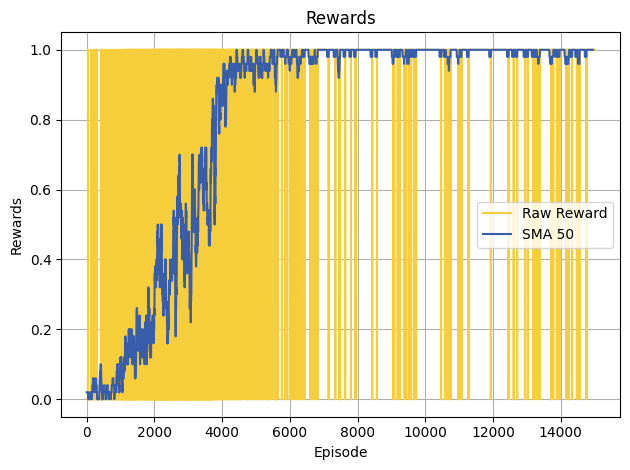

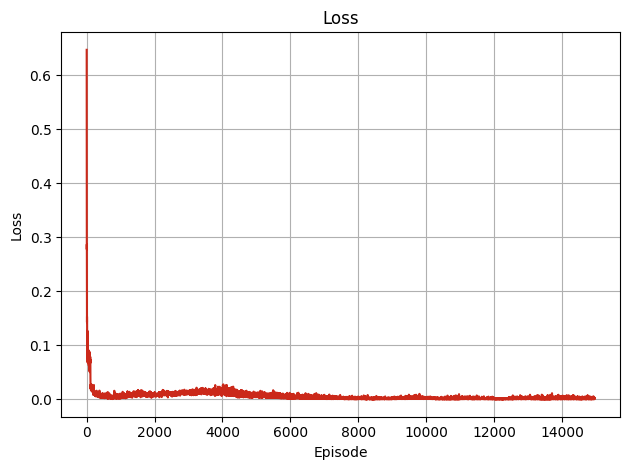

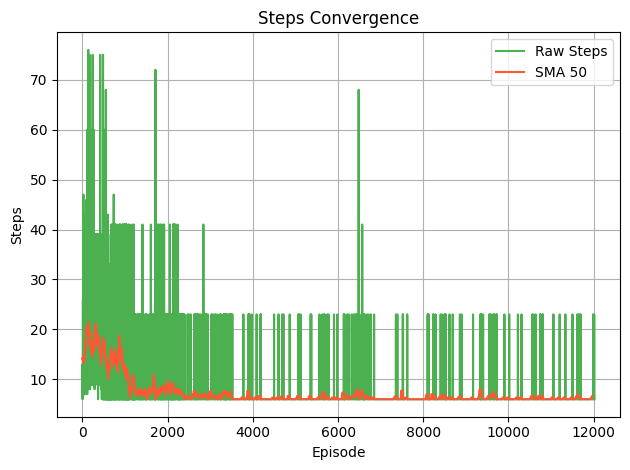

In [16]:

# Import necessary modules
import os
import gc
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym
from agent.base_agent import BaseAgent
from collections import Counter
from utils import seed_everything
import pandas as pd

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment setup
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Set CUDA launch blocking to 1 for debugging CUDA-related errors

df=pd.DataFrame(columns=[i for i in range(64)])
def df_append(df, new_data):
    """
    Append new data to a DataFrame, keeping only three decimal places.
    """
    # 保留三位小数
    new_data = np.round(new_data, 4)
    new_row = pd.DataFrame([new_data], columns=df.columns)
    df = pd.concat([df, new_row], ignore_index=True)
    return df


# Replay Buffer Class
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Experience replay buffer used to store transitions
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, next_state, reward, done):
        """
        Store a transition in the buffer
        """
        self.buffer.append((state, action, next_state, reward, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer
        """
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        states, actions, next_states, rewards, dones = zip(*(self.buffer[idx] for idx in indices))

        # Convert sampled transitions to tensors
        states = torch.stack(states).to(device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        next_states = torch.stack(next_states).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones

    def __len__(self):
        return len(self.buffer)

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        初始化优先级经验回放缓冲区
        
        参数:
        - capacity: 缓冲区的最大容量
        - alpha: 优先级的程度 (alpha=0表示均匀采样，alpha=1表示完全优先级采样)
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.epsilon = 1e-5  # 防止优先级为零的小常数

    def store(self, state, action, next_state, reward, done):
        """
        存储一个经验
        初始时，我们将优先级设置为最大值（表示高度优先级）
        """
        max_priority = max(self.priorities) if self.priorities else 1.0
        self.buffer.append((state, action, next_state, reward, done))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        """
        使用优先级采样一批经验
        
        参数:
        - batch_size: 采样的批大小
        - beta: 用于调整重要性采样权重的参数
        
        返回:
        - states, actions, next_states, rewards, dones, weights: 采样的批次及对应的权重
        """
        # 计算优先级的概率
        priorities = np.array(self.priorities) ** self.alpha
        probabilities = priorities / priorities.sum()

        # 按照计算出的概率采样
        indices = np.random.choice(len(self.buffer), size=batch_size, p=probabilities)

        # 获取采样的批次
        states, actions, next_states, rewards, dones = zip(*(self.buffer[idx] for idx in indices))

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()  # 归一化权重

        # 转换为张量
        states = torch.stack(states).to(device)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        next_states = torch.stack(next_states).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.bool, device=device)
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

        return states, actions, next_states, rewards, dones, weights, indices  # 返回 indices

    def update_priorities(self, indices, td_errors):
        """
        根据 TD error 更新优先级
        
        参数:
        - indices: 采样的索引
        - td_errors: 采样的 TD error
        """
        for idx, td_error in zip(indices, td_errors):
            priority = (abs(td_error) + self.epsilon) ** self.alpha
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)
    
class Qnet(nn.Module):
    def __init__(self, num_actions, input_dim):
        """
        Neural network for Deep Q-Learning
        """
        super(Qnet, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_actions)
        )
        self._initialize_weights()

    def forward(self, x):
        """
        Forward pass through the network
        """
        return self.fc_layers(x)


    def _initialize_weights(self):
        """
        Initialize weights for linear layers using Kaiming uniform initialization
        """
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # 用一种特殊的方式初始化神经网络参数

class DuelingQnet(nn.Module):
    def __init__(self, num_actions, input_dim):
        super(DuelingQnet, self).__init__()
        
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_actions)
        )
        self._initialize_weights()


    def forward(self, state):
        features = self.feature_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        Qvals = values + (advantages - advantages.mean())  # 共享一个基础值+ 对应的action优势
        
        return Qvals

    def _initialize_weights(self):
        """
        Initialize weights for linear layers using Kaiming uniform initialization
        """
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                # if layer.bias is not None:
                #     nn.init.constant_(layer.bias, 0)

# DQN Agent Class inheriting from Agent
class DQNAgent(BaseAgent):
    def __init__(self, env, hyperparams, dueling=False, priority=False):
        """
        DQN Agent class for interacting with the environment and learning
        """
        super(DQNAgent, self).__init__(env, hyperparams)
        
        if priority:
            self.replay_memory = PrioritizedReplayBuffer(hyperparams['memory_capacity'])
            self.learn = self.learn_priority
        else:
            self.replay_memory = ReplayBuffer(hyperparams['memory_capacity'])
            self.learn = self.learn_standard

        # Main and target networks
        if dueling:
            self.model = DuelingQnet(self.num_actions, self.state_dim).to(device)
            self.target_network = DuelingQnet(self.num_actions, self.state_dim).to(device)
        else:
            self.model = Qnet(self.num_actions, self.state_dim).to(device)  # state dimension 就是神经网络输入的 维度 （10）
            self.target_network = Qnet(self.num_actions, self.state_dim).to(device)
        self.update_target_network()

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.model.parameters(), lr=hyperparams['learning_rate'])
        self.criterion = nn.MSELoss()
        
        # Additional hyperparameters
        self.discount = hyperparams['discount_factor']
        self.epsilon = hyperparams['epsilon_max']
        self.epsilon_min = hyperparams['epsilon_min']
        self.epsilon_decay = hyperparams['epsilon_decay']
        self.clip_grad_norm = hyperparams['clip_grad_norm']
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        with torch.no_grad():
            Q_values = self.model(state)
            return torch.argmax(Q_values).item()

    def learn_standard(self, batch_size, done, double_dqn=False):
        """
        Learn from a batch of experiences using the DQN update rule
        """
        # Sample a batch from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        
        predicted_q = self.model(states).gather(dim=1, index=actions)  # self.model是什么？
        with torch.no_grad():  # 计算下一个网络的最大Q值
            if double_dqn:
                next_actions = self.model(next_states).argmax(dim=1, keepdim=True)
                next_target_q_value = self.target_network(next_states).gather(dim=1, index=next_actions)
            else:
                next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
                
        next_target_q_value[dones] = 0
        y_js = rewards + (self.discount * next_target_q_value)  #计算 Q 值
        # Compute loss
        loss = self.criterion(predicted_q, y_js)  # 计算预测值和目标值之间的差异，作为loss
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss, self.learned_counts = 0, 0
        # Backpropagate the loss反向传播梯度，并用Adam优化器更新参数
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
        self.optimizer.step()

    def learn_priority(self, batch_size, done, double_dqn=False):
        """
        Learn from a batch of experiences using the DQN update rule
        """
        # Sample a batch from the replay buffer
        states, actions, next_states, rewards, dones, weights, indices = self.replay_memory.sample(batch_size)
        actions = actions.unsqueeze(1)
        # rewards 和 dones 都是一维的，需要转换成二维的, 但是reward/dones 对大部分数据来说都是0 & 1？
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        
        # Compute predicted Q-values and target Q-values
        predicted_q = self.model(states).gather(dim=1, index=actions)
        with torch.no_grad():  # 计算下一个网络的最大Q值
            if double_dqn:
                next_actions = self.model(next_states).argmax(dim=1, keepdim=True)
                next_target_q_value = self.target_network(next_states).gather(dim=1, index=next_actions)
            else:
                next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
                
        next_target_q_value[dones] = 0  # 如果是终止状态，目标 Q 值为 0
        y_js = rewards + (self.discount * next_target_q_value)  
        # Compute loss
        loss = self.criterion(predicted_q, y_js)
        loss = loss * weights
        loss = loss.mean() # 计算最终的损失（对批次求均值）
        
        self.running_loss += loss.item()
        self.learned_counts += 1
        if done:
            self.loss_history.append(self.running_loss / self.learned_counts)
            self.running_loss, self.learned_counts = 0, 0
        # Backpropagate the loss反向传播梯度，并用Adam优化器更新参数
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
        self.optimizer.step()
        
        td_errors = (predicted_q - y_js).squeeze().detach().cpu().numpy()
        self.replay_memory.update_priorities(indices, td_errors)
    
    def update_target_network(self):
        """
        Update the target network by copying weights from the main network
        """
        self.target_network.load_state_dict(self.model.state_dict())

    def update_epsilon(self):
        """
        Update epsilon value for epsilon-greedy policy
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """
        Save the trained model
        """
        torch.save(self.model.state_dict(), path)

    
    def load(self, path):
        """
        Load the trained model
        """
        self.model.load_state_dict(torch.load(path, map_location=device))

# Trainer Class
class Trainer:
    def __init__(self, env, agent, hyperparams, double_dqn=False):
        """
        Trainer class to manage training and evaluation of the agent
        """
        self.env = env  # 提供章台 奖励 和 转移逻辑
        self.agent = agent
        self.hyperparams = hyperparams
        self.reward_history = []
        self.step_history = []
        self.double_dqn = double_dqn
        if hasattr(agent, 'replay_memory'):
            self.use_replay_memory = True
        else:
            self.use_replay_memory = False

    def state_preprocess(self, state):
        """
        Convert the state to one-hot representation 
        """
        onehot_vector = torch.zeros(self.env.observation_space.n, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector

    def train(self):
        """
        Train the agent for a specified number of episodes
        """
        global df
        
        total_steps = 0
        for episode in range(1, self.hyperparams['max_episodes'] + 1):
            # 每轮训练初始状态重置
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            # 开玩
            while not done and not truncation:
                # Select and execute an action
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state)

                # use ReplayBuffer
                if self.use_replay_memory:
                # 如果有replay buffer, 将当前交互存入(s,a,r,s′)
                    self.agent.replay_memory.store(state, action, next_state, reward, done)
                    if len(self.agent.replay_memory) > self.hyperparams['batch_size'] and sum(self.reward_history) > 0:
                        # 当 buffer 的数量足够多时，随机采取一定的批量进行学习
                        self.agent.learn(self.hyperparams['batch_size'], (done or truncation), self.double_dqn)
                        # Update target network periodically
                        # 相隔一段时间就把目标网络更新一下 (由 update frequency 决定)
                        if total_steps % self.hyperparams['update_frequency'] == 0:
                            self.agent.update_target_network()

                state = next_state
                episode_reward += reward
                step_size += 1
            # if reward == 1:
            self.reward_history.append(episode_reward)  # 全体 reward
            if reward == 1:
                self.step_history.append(step_size)  # Track steps for each episode
            total_steps += step_size
            self.agent.update_epsilon()

            # 保存模型和打印日志
            if episode % self.hyperparams['save_interval'] == 0:
                os.makedirs(self.hyperparams['model_dir'], exist_ok=True)
                self.agent.save(os.path.join(self.hyperparams['model_dir'], f'{episode}.pth'))
                print('\n~~~~~~Interval Save: Model saved.\n')
            # Print episode information at specified intervals
            if episode % self.hyperparams['print_interval'] == 0:
                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon:.2f}")
                
            if (episode%1000==0 and len(self.agent.replay_memory.buffer)>0):
                print("episode", episode, " ", print_replay_buffer_frequency(self.agent)[:10])
                
            # 如果需要输出Q table
            # if episode%100==0:
            #     Q_table = self.agent.model(torch.eye(16).to(device)).detach().cpu().numpy()
            #     df=df_append(df, Q_table[:, [3, 0, 2, 1]].flatten())

        self.plot_training(episode)


    def test(self, max_episodes=None):
        """
        Test the trained agent
        """
        # Load the trained model
        self.agent.load(os.path.join(self.hyperparams['model_dir'], f"{self.hyperparams['train_episodes']}.pth"))
        self.agent.model.eval()

        if max_episodes is None:
            max_episodes = self.hyperparams['max_episodes']

        for episode in range(1, max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                # Select an action
                state = self.state_preprocess(state)
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                state = next_state
                episode_reward += reward
                step_size += 1

            # Print episode information
            print(f"Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")


    def plot_training(self, episode):
        """
        Plot the training reward history, loss history, and step convergence
        """
        # Plot Rewards
        print(np.sum(self.reward_history))

        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            os.makedirs(self.hyperparams['plot_dir'], exist_ok=True)
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Loss
        plt.figure()
        plt.title("Loss")
        plt.plot(self.agent.loss_history, label='Loss', color='#CB291A', alpha=1)
        plt.xlabel("Episode")
        plt.ylabel("Loss")
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'loss_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # Plot Steps Convergence
        sma_steps = np.convolve(self.step_history, np.ones(50)/50, mode='valid')
        plt.figure()
        plt.title("Steps Convergence")
        plt.plot(self.step_history, label='Raw Steps', color='#4CAF50', alpha=1)
        plt.plot(sma_steps, label='SMA 50', color='#FF5733')
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'steps_plot.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

def print_replay_buffer_frequency(agent):
    buffer = agent.replay_memory.buffer  # 替换为你的实际 Replay Buffer

    # 将五元组转换为 hashable 的元组（因为 tensor 不可直接作为字典键）
    hashable_buffer = [
        (
            tuple(state.cpu().numpy()),  # 将 Tensor 转换为元组
            action,
            tuple(next_state.cpu().numpy()),  # 将 Tensor 转换为元组
            reward,
            done
        )
        for (state, action, next_state, reward, done) in buffer
    ]

    # 使用 Counter 统计每个样本的频率
    frequency = Counter(hashable_buffer)

    # 按频率排序并打印
    sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

    counts=[]
    print("Sample\tFrequency")
    for sample, count in sorted_frequency:
        counts.append(count)
    return counts


# Main Function to Set Up and Train/Test the Model
if __name__ == "__main__":
    method_name = "dqn"
    train_mode = True

    train_episodes = 15000
    render = not train_mode
    map_size = 4 # Start with 4x4 map
    seed = 1

    # build config
    config = {
        "train_mode": train_mode,
        "method_name": method_name,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/',
        "save_interval": 500,
        "print_interval": 100,
        "clip_grad_norm": 5,
        "learning_rate": 4e-4,
        "discount_factor":0.9,
        "batch_size": 32,
        "update_frequency": 30,
        "max_episodes": train_episodes if train_mode else 10,
        "train_episodes": train_episodes,
        "max_steps": 200,
        "render": render,
        "epsilon_max": 0.99 if train_mode else -1,
        "epsilon_min": 0.001,
        "epsilon_decay": 0.999,
        "memory_capacity": 5000 if train_mode else 0,
        "map_size": map_size,
        "render_fps": 6,
    }

    # set seed
    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1', 
        map_name=f"{config['map_size']}x{config['map_size']}", 
        is_slippery=True, 
        max_episode_steps=config['max_steps'], 
        render_mode="human" if config['render'] else None)

    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    # Create agent and trainer
    agent = DQNAgent(env, config, dueling=False, priority=False)
    trainer = Trainer(env, agent, config, double_dqn=False)

    # Train or test
    if config['train_mode']:
        trainer.train()
    else:
        trainer.test()
